In [47]:
import torch 
from setup import fetch_data 
from plotting import plot_from_dataset, plot_random_image

# use GPU if available 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# define constants 
BATCH_SIZE = 32
IMAGE_SIZE = 224

# load dataset and dataloaders 

train_data, test_data, train_dataloader, test_dataloader = fetch_data(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
labels_dict = train_data.idx_to_class

cpu


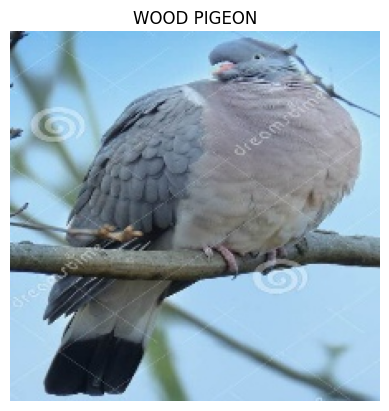

In [49]:
plot_from_dataset(train_data, labels_dict, 500); 

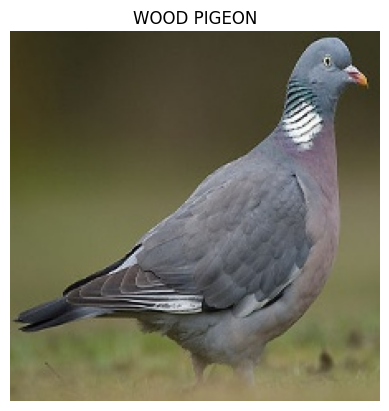

In [48]:
plot_random_image("data/reduced"); 

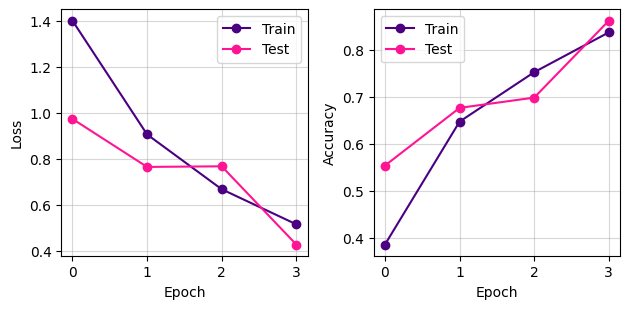

In [28]:
# loading model 
from plotting import plot_results
from utils import load_model, load_results
from models import TinyVGG 

# load the model
model_loaded = TinyVGG(in_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  out_shape=len(train_data.classes),
                  name="TinyVGG_5class").to(device)
load_model(model_loaded, f"{model_loaded.name}.pth")
# model_loaded.state_dict() 

model_results = load_results(f"{model_loaded.name}")

plot_results(model_results)

In [88]:
# test the model on an image it has not seen 
import requests
import pathlib
image_path = pathlib.Path("data/reduced/validation/HOUSE SPARROW.jpg")
image_url = "https://cdn.download.ams.birds.cornell.edu/api/v1/asset/612827980/1200"

if not image_path.is_file():
    try: 
        r = requests.get(image_url)
        if r.status_code == 200: 
            with open(image_path, "wb") as f: 
                f.write(r.content)
                print("[INFO] Writing to file...")
    except: 
        print("Exception occurred")

[INFO] Writing to file...


Predicted label: AUSTRALIAN MAGPIE with 99.64% probability.


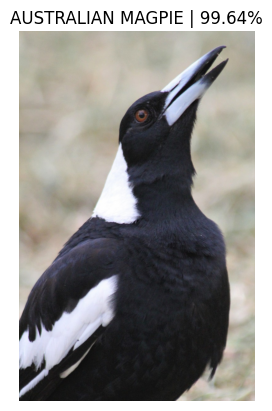

In [31]:
import torchvision
import matplotlib.pyplot as plt
from utils import load_custom_image
from engine import predict

custom_image = load_custom_image("AUSTRALIAN MAGPIE", image_size=128)
probs, prediction = predict(model=model_loaded, image_tensor=custom_image, labels_dict=labels_dict, device=device)


probs, prediction = predict(model=model_loaded, image_tensor=custom_image,labels_dict=labels_dict, device=device)

plt.imshow(custom_image.to("cpu").permute(1,2,0)) 
plt.axis("off") 
plt.title(f"{prediction} | {probs.max() * 100:.2f}%")
plt.show()

In [61]:
from engine import train 
from utils import save_model, save_results

# transfer learning 
model = torchvision.models.efficientnet_b0(weights='DEFAULT').to(device)
for param in model.features.parameters():
    # turn off gradient tracking  
    param.requires_grad = False 

# change out_features for the classifier head
model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=1280, out_features=len(train_data.classes))
).to(device)
model.name = "effnet_b0_5class"

# optimizer and loss
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=train_dataloader, epochs=4, loss_fn=loss_fn, optimizer=optimizer, device=device)

# save the model and the results 
save_model(model, f"{model.name}.pth")
save_results(model.name, model_results)

***** EPOCH 0 *****
LOSS:     TRAIN = 1.092 | TEST = 0.639
ACCURACY: TRAIN = 0.716 | TEST = 0.948
***** EPOCH 1 *****
LOSS:     TRAIN = 0.479 | TEST = 0.281
ACCURACY: TRAIN = 0.967 | TEST = 0.984
***** EPOCH 2 *****
LOSS:     TRAIN = 0.293 | TEST = 0.185
ACCURACY: TRAIN = 0.976 | TEST = 0.991
***** EPOCH 3 *****
LOSS:     TRAIN = 0.209 | TEST = 0.135
ACCURACY: TRAIN = 0.983 | TEST = 0.993
[INFO] Save successful
[INFO] Successfully written changes


In [92]:
# for reloading the modules 
import importlib
import utils, engine, plotting
importlib.reload(plotting)

<module 'plotting' from 'c:\\Users\\xd_mo\\Projects\\birdify\\plotting.py'>

Predicted label: HOUSE SPARROW with 52.10% probability.


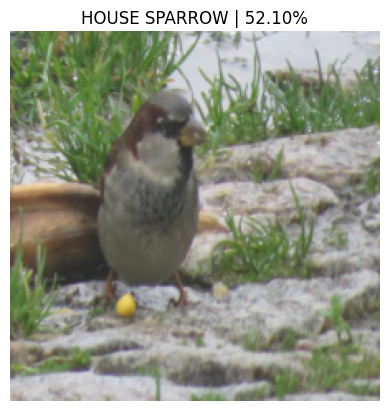

In [94]:
from plotting import plot_prediction 

custom_image = load_custom_image("HOUSE SPARROW", image_size=224)
probs, prediction = predict(model=model, image_tensor=custom_image, labels_dict=labels_dict, device=device)

plot_prediction(custom_image, probs, prediction); 
